In [1]:
pip install -q datasets transformers evaluate timm albumentations

In [2]:
pip install datasets

In [3]:
import json
with open('result.json') as f:
 cocodata = json.load(f)


In [4]:
# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
    # Remove the image directory from the file name
    image['file_name'] = image['file_name'].split('/')[-1]
    print(image['file_name'])
    image['image_id'] = image['id']
    # Extend the image dict with bounding boxes and class labels
    image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
    # Iterate through the annotations (bounding boxes and labels)
    for annot in cocodata['annotations']:
        # Check if the annotation matches the image
        if annot['image_id'] == image['id']:
            # Add the annotation
            image['objects']['bbox'].append(annot['bbox'])
            image['objects']['category'].append(annot['category_id'])
            image['objects']['area'].append(annot['area'])
            image['objects']['id'].append(annot['id'])
    # Append the image dict with annotations to the list
    huggingdata.append(image)


images\78cc273c-cd_22.jpg
images\1cc446bd-cd_23.jpg
images\076d8054-cd_24.jpg
images\1fd867f0-cd_32.jpg
images\b7977893-cd_34.jpg
images\d43784e0-cd_04.jpg
images\c16e54a0-cd_07.jpg
images\102a6981-cd_08.jpg
images\bb99107d-cd_09.jpg
images\4be56601-cd_10.jpg


In [5]:
image['file_name']

'images\\4be56601-cd_10.jpg'

In [6]:
#I need to clean up the file names cus the 'images\\' string is causing issues

for item in huggingdata:
    if 'file_name' in item and isinstance(item['file_name'], str):
        print('x')
        item['file_name'] = item['file_name'].replace("images\\", "")

x
x
x
x
x
x
x
x
x
x


In [7]:
import os

train_folder = "/content/train"

# Ensure the 'train' folder exists, create it if necessary
if not os.path.exists(train_folder):
    os.makedirs(train_folder)

# Specify the path to the metadata file in the 'train' folder
metadata_file_path = os.path.join(train_folder, "metadata.jsonl")

# Write the metadata to the file in the 'train' folder
with open(metadata_file_path, 'w') as f:
    for item in huggingdata:
        f.write(json.dumps(item) + "\n")


In [8]:
metadata_file_path

'/content/train/metadata.jsonl'

In [10]:
from datasets import load_dataset
data_dir = r"train/"
candy_data = load_dataset('imagefolder', data_dir=data_dir)

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [11]:
candy_data

DatasetDict({
    train: Dataset({
        features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
        num_rows: 10
    })
})

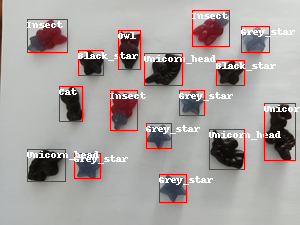

In [12]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = candy_data["train"][0]["image"]
annotations = candy_data["train"][0]["objects"]
draw = ImageDraw.Draw(image)

id2label = {item['id']: item['name'] for item in cocodata['categories']} #These 2 lines of code are replaced with what is given to us in A2
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [13]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [14]:
pip install albumentations

In [15]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [16]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [17]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [18]:
candy_data["train"] = candy_data["train"].with_transform(transform_aug_ann)
candy_data["train"][0]

{'pixel_values': tensor([[[ 2.2318,  2.2318,  2.2318,  ..., -0.9534, -0.9363, -0.9363],
          [ 2.2318,  2.2318,  2.2318,  ..., -0.9534, -0.9363, -0.9363],
          [ 2.2318,  2.2318,  2.2318,  ..., -0.9363, -0.9363, -0.9363],
          ...,
          [ 1.7009,  1.7009,  1.7009,  ...,  1.5297,  1.5297,  1.5297],
          [ 1.7009,  1.7009,  1.7009,  ...,  1.5125,  1.5125,  1.5125],
          [ 1.7009,  1.7009,  1.7009,  ...,  1.5125,  1.5125,  1.5125]],
 
         [[ 2.4286,  2.4286,  2.4286,  ..., -0.4251, -0.3901, -0.3725],
          [ 2.4286,  2.4286,  2.4286,  ..., -0.4251, -0.3901, -0.3725],
          [ 2.4286,  2.4286,  2.4286,  ..., -0.4251, -0.3901, -0.3725],
          ...,
          [ 1.9559,  1.9559,  1.9559,  ...,  1.6933,  1.6933,  1.6933],
          [ 1.9559,  1.9559,  1.9559,  ...,  1.6933,  1.6933,  1.6933],
          [ 1.9559,  1.9559,  1.9559,  ...,  1.6933,  1.6933,  1.6933]],
 
         [[ 2.6400,  2.6400,  2.6400,  ...,  0.6182,  0.7054,  0.7576],
          [ 

In [19]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [20]:
pip install timm

In [21]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [22]:
pip install transformers[torch]

In [23]:
pip install accelerate -U

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_candy",
    per_device_train_batch_size=8,
    num_train_epochs=600, #bumped count from 10 to 600
    fp16=True,
    save_steps=200,
    logging_steps=10, #changed to 10 from 50
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False, #Setting this to false because I don't need to push to hub
)

In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=candy_data["train"],
    tokenizer=image_processor,
)

trainer.train()

Step,Training Loss
10,3.693300
20,2.578600
30,2.406900
40,2.340200
50,2.287300
60,2.232500
70,2.180100
80,2.150900
90,2.118300
100,2.074800


TrainOutput(global_step=1200, training_loss=1.014663847287496, metrics={'train_runtime': 1047.0362, 'train_samples_per_second': 5.73, 'train_steps_per_second': 1.146, 'total_flos': 2.86694809344e+18, 'train_loss': 1.014663847287496, 'epoch': 600.0})

In [26]:
trainer.save_model('candy_detector')

In [32]:
#Let's see how good our model is at detecting
from PIL import Image
from transformers import pipeline
import requests

file_path = "cd_35.jpg"

# Open the image file
image = Image.open(file_path)

In [33]:
image_processor = AutoImageProcessor.from_pretrained("candy_detector")
model = AutoModelForObjectDetection.from_pretrained("candy_detector")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected Unicorn_whole with confidence 0.273 at location [41.78, 151.9, 83.11, 178.17]
Detected Black_star with confidence 0.557 at location [85.62, 116.13, 108.13, 137.99]
Detected Unicorn_head with confidence 0.4 at location [34.63, 60.95, 71.57, 83.57]
Detected Moon with confidence 0.746 at location [200.55, 141.37, 230.5, 166.75]
Detected Unicorn_head with confidence 0.724 at location [206.44, 83.72, 235.15, 122.9]
Detected Black_star with confidence 0.617 at location [110.95, 157.43, 133.51, 181.55]
Detected Black_star with confidence 0.813 at location [117.9, 41.02, 141.03, 67.93]
Detected Unicorn_whole with confidence 0.424 at location [147.46, 32.26, 179.25, 79.48]
Detected Insect with confidence 0.693 at location [188.81, 47.13, 229.81, 70.92]
Detected Insect with confidence 0.613 at location [85.61, 186.05, 116.47, 217.47]
Detected Black_star with confidence 0.782 at location [94.68, 88.61, 118.94, 113.8]
Detected Unicorn_whole with confidence 0.553 at location [65.79, 9.3, 1

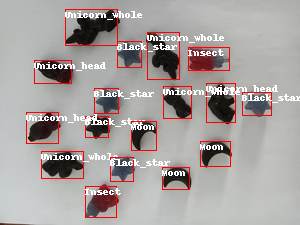

In [34]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

In [35]:
def candy_counter(image):
    image_processor = AutoImageProcessor.from_pretrained("candy_detector")
    model = AutoModelForObjectDetection.from_pretrained("candy_detector")

    #list of all possible objects
    possible_objects = ["Moon", "Insect", "Black_star", "Grey_star", "Unicorn_whole", "Unicorn_head", "Owl", "Cat"]

    #initialize object counts with zeros for each obj
    object_counts = {object_name: 0 for object_name in possible_objects}

    with torch.no_grad():
        inputs = image_processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        results = image_processor.post_process_object_detection(outputs, threshold=0.2, target_sizes=target_sizes)[0]

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        object_name = model.config.id2label[label.item()]
        confidence = round(score.item(), 3)

        # Increment the count for the detected object
        object_counts[object_name] += 1

    return object_counts

In [36]:
file_path = "cd_35.jpg"

# Open the image file
image = Image.open(file_path)

candy_counter(image)

{'Moon': 3,
 'Insect': 2,
 'Black_star': 5,
 'Grey_star': 0,
 'Unicorn_whole': 4,
 'Unicorn_head': 3,
 'Owl': 0,
 'Cat': 0}